In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
import requests
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud



In [3]:
# science
urls = []
# url 변화하는거 적당히 보고 알아서 잘 해야됨. 페이지 단위로 넘어가는게 아니라면 selenium 써야할 수도 있음.
url = 'https://search.sciencemag.org/?searchTerm=kaist&order=newest&limit=textFields&pageSize=100&startDate=2015-01-01&&'
browser = webdriver.Chrome('/Users/user/Desktop/chromedriver_win32/chromedriver.exe')
browser.get(url)
timeout = 30
try:
    element_present = EC.presence_of_element_located((By.CLASS_NAME, 'media__headline'))
    WebDriverWait(browser, timeout).until(element_present)
except Exception as e :
    print(e)
    print("Timed out waiting for page to load")
html = browser.page_source
soup = bs(html, "html.parser")
elements = soup.select('.media__headline a[href]')
for element in elements:
    link = element.attrs['href']
    urls.append(link)
browser.quit()

print('Whole post num : {}'.format(len(urls)))


Whole post num : 51


In [40]:
titles = []
contents = []
for i,url in enumerate(urls):
    response = requests.get(url)
    html = response.text
    soup = bs(html,'html.parser')
    try: 
        response = requests.get(url)    
        html = response.text
        soup = bs(html,'html.parser')
        content = soup.select('.abstract p')[0].get_text() # select 안에 본문에 해당하는 id 값을 찾아서 넣어주면 됨.
        content = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', content)
        title = soup.select('.highwire-cite-title')[0].get_text()
    except Exception as e: 
        print(content,title)
    contents.append(content)
    titles.append(title)
    if i%10 == 0:
        print(i)


0
10
20
30
Highprecision monitoring of electrophysiological signals with high spatial and temporal resolutions is one of the most important subjects for elucidating physiology functions Recently ultraflexible multielectrode arrays MEAs have been fabricated to establish conformal contacts with the surface of organs and to measure propagation of electrophysiological signals with high spatialtemporal resolution; however plastic substrates have high Young’s modulus causing difficulties in creating appropriate stretchability and blood compatibility for applying them on the dynamically moving and surgical bleeding surface of the heart Here we have successfully fabricated an active MEA that simultaneously achieves nonthrombogenicity stretchability and stability which allows longterm electrocardiographic ECG monitoring of the dynamically moving hearts of rats even with capillary bleeding Because of the active data readout the measured ECG signals exhibit a high signaltonoise ratio of 52 dB The

In [46]:
data = {"title" : titles,"content": contents,"url": urls}
df = pd.DataFrame(data)
df['content'] =df['content'].map(lambda x : x.replace('\r',""))
df.head()
df.to_pickle('science_post.pickle')

,title,content,url
0,Electro-inductive effect: Electrodes as functi...,In place of functional groups that impose diff...,https://science.sciencemag.org/content/370/651...
1,Harnessing the topotactic transition in oxide ...,Mobile oxygen vacancies offer a substantial po...,https://advances.sciencemag.org/content/6/41/e...
2,Characterization of ANGPT2 mutations associate...,Primary lymphedema is caused by developmental ...,https://stm.sciencemag.org/content/12/560/eaax...
3,A Janus emitter for passive heat release from ...,Passive radiative cooling functions by reflect...,https://advances.sciencemag.org/content/6/36/e...
4,Polymer blend directed anisotropic self-assemb...,Anisotropic mesoporous inorganic materials hav...,https://advances.sciencemag.org/content/6/33/e...


In [4]:
df = pd.read_pickle('science_post.pickle')

In [5]:
# Data Preprocessing
def preprocess(text):
    # tokenize into words
    text = re.sub('[^A-Za-z ]', '', text)
    tokens = [word for sent in nltk.sent_tokenize(text)
              for word in nltk.word_tokenize(sent)]
    # remove stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop + call_stopwords() + ['this']]
    # remove words less than three letters
    tokens = [word for word in tokens if len(word) >= 3]
        # lower capitalization
    tokens = [word.lower() for word in tokens]
        # lemmatization
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(word) for word in tokens]
    tokens = [lmtzr.lemmatize(word, 'v') for word in tokens]
    # stemming
    return tokens

In [6]:
def call_stopwords():
    with open('stopwords.txt','r') as f:
        stopwords = f.readlines()
        stopwords = list(map((lambda x: x.rstrip('\n')),stopwords))
    return stopwords


In [7]:
def english_tokenize(df):
    titles_token = []
    contents_token = []
    for i,row in enumerate(df.itertuples()):
        title_token = []
        content_token = []
        title = getattr(row, 'title')
        content = getattr(row, 'content')
        title_token = preprocess(title)
        content_token = preprocess(content)
        titles_token.append(title_token)
        contents_token.append(content_token)
        if i%10==0 :
            print(i)
    df['title_token'] = titles_token
    df['content_token'] = contents_token
    return df

In [8]:
df = english_tokenize(df)
df.head()

0
10
20
30
40
50


,title,content,url,title_token,content_token
0,Electro-inductive effect: Electrodes as functi...,In place of functional groups that impose diff...,https://science.sciencemag.org/content/370/651...,"[electroinductive, effect, electrode, function...","[functional, impose, inductive, effect, immobi..."
1,Harnessing the topotactic transition in oxide ...,Mobile oxygen vacancies offer a substantial po...,https://advances.sciencemag.org/content/6/41/e...,"[harness, topotactic, transition, oxide, heter...","[mobile, oxygen, vacancy, offer, substantial, ..."
2,Characterization of ANGPT2 mutations associate...,Primary lymphedema is caused by developmental ...,https://stm.sciencemag.org/content/12/560/eaax...,"[characterization, angpt, mutation, associate,...","[primary, lymphedema, cause, developmental, fu..."
3,A Janus emitter for passive heat release from ...,Passive radiative cooling functions by reflect...,https://advances.sciencemag.org/content/6/36/e...,"[janus, emitter, passive, heat, release, enclo...","[passive, radiative, cool, function, reflect, ..."
4,Polymer blend directed anisotropic self-assemb...,Anisotropic mesoporous inorganic materials hav...,https://advances.sciencemag.org/content/6/33/e...,"[polymer, blend, direct, anisotropic, selfasse...","[anisotropic, mesoporous, inorganic, material,..."


In [9]:
def identity_tokenizer(text):
    """
    sklearn의 Tfidfvectorizer를 이용함에 있어서 우리의 nori 토크나이저가 토큰화 한 결과를 사용하기 위한 method이다.

    :param text: 토큰화 하고자 하는 문장
    :return: 토큰이 담긴 리스트가 반환된다.
    """
    list1 = text.split('00')
    return list1

In [10]:
def TfidfWord(df):
    #TF-IDF를 기반으로 카이스트 검색시 가장 의미가 높은 단어로 예상되는 단어 100가지를 추출함.

    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,
                                    max_features=100,
                                    max_df=0.5,
                                    ngram_range=(1, 1))

    # content를 기반으로 TF-IDF를 돌리는 함수
    words_list_content = []
    token_concat = df['content_token'].map(lambda x: "00".join(x))
    tfidf_matrix = vectorizer.fit_transform(token_concat)
    tfidf_wordslist = vectorizer.get_feature_names()
    vocab = dict()
    for idx, word in enumerate(tfidf_wordslist):
        vocab[word] = tfidf_matrix.getcol(idx).sum()
    words_list_content = sorted(vocab.items(), key=lambda x: x[1], reverse=True)


    # title을 기반으로 TF-IDF를 돌리는 함수
    words_list_title = []
    token_concat = df['title_token'].map(lambda x: "00".join(x))
    tfidf_matrix = vectorizer.fit_transform(token_concat)
    tfidf_wordslist = vectorizer.get_feature_names()
    vocab = dict()
    for idx, word in enumerate(tfidf_wordslist):
        vocab[word] = tfidf_matrix.getcol(idx).sum()
    words_list_title = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

    return words_list_content, words_list_title

In [11]:
def CountWord(df):
    #단어가 나온 빈도수를 기반으로 카이스트 검색시 가장 의미가 높은 단어로 예상되는 단어 100가지를 추출함.

    vectorizer = CountVectorizer(tokenizer=identity_tokenizer,
                                    max_features=100,
                                    max_df=0.5,
                                    ngram_range=(1, 1))

    # content를 기반으로 TF-IDF를 돌리는 함수
    words_list_content = []
    token_concat = df['content_token'].map(lambda x: "00".join(x))
    tfidf_matrix = vectorizer.fit_transform(token_concat)
    tfidf_wordslist = vectorizer.get_feature_names()
    vocab = dict()
    for idx, word in enumerate(tfidf_wordslist):
        vocab[word] = tfidf_matrix.getcol(idx).sum()
    words_list_content = sorted(vocab.items(), key=lambda x: x[1], reverse=True)


    # title을 기반으로 를 돌리는 함수
    words_list_title = []
    token_concat = df['title_token'].map(lambda x: "00".join(x))
    tfidf_matrix = vectorizer.fit_transform(token_concat)
    tfidf_wordslist = vectorizer.get_feature_names()
    vocab = dict()
    for idx, word in enumerate(tfidf_wordslist):
        vocab[word] = tfidf_matrix.getcol(idx).sum()
    words_list_title = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

    return words_list_content, words_list_title

In [12]:
TF_content_word, TF_title_word= TfidfWord(df)
Count_content_word, Count_title_word= CountWord(df)

In [13]:

def word_tuple2dict(tups):
    target_dict =dict((x,y) for x,y in tups)
    for key in list(target_dict.keys()):
        if len(key) ==1 :
           del target_dict[key]
    return target_dict

In [15]:
print('==================TF_CONTENT=============\n')
TF_content_word_dict=word_tuple2dict(TF_content_word[:15])
print(TF_content_word_dict)
print('==================TF_title=============\n')
TF_title_word_dict=word_tuple2dict(TF_title_word[:15])
print(TF_title_word_dict)
print('==================Count_CONTENT=============\n')
Count_content_word_dict=word_tuple2dict(Count_content_word[:15])
print(Count_content_word_dict)
print('==================Count_title=============\n')
Count_title_word_dict=word_tuple2dict(Count_title_word[:15])
print(Count_title_word_dict)

==================TF_CONTENT=============

{'material': 3.1788779923011843, 'surface': 3.1432841652565626, 'cell': 3.0823774506766974, 'catalyst': 2.6955261440321485, 'signal': 2.384598456013025, 'device': 2.3688323064753467, 'robot': 2.292894588958136, 'here': 2.23475983286329, 'process': 2.1904300010913955, 'application': 2.1783517769281517, 'find': 2.0775832027584067, 'result': 2.0569387512995627, 'system': 2.0101263589498286, 'method': 2.006053391666053, 'this': 1.9993008888752777}
==================TF_title=============

{'stable': 1.7635906030064157, 'cell': 1.610491688137787, 'electrode': 1.5917022320589873, 'liquid': 1.5773502691896257, 'wave': 1.5773502691896257, 'soft': 1.3612230918287171, 'via': 1.2482700947061691, 'elastic': 1.2280627837065818, 'mxene': 1.169052501248613, 'resistance': 1.1585581472558926, 'catalyst': 1.1547005383792515, 'transition': 1.1547005383792515, 'polymer': 1.1453317837717865, 'tie': 1.1453317837717865, 'transparent': 1.1453317837717865}
============

In [16]:
fontpath = './font/NanumGothic.ttf'
wc = WordCloud(
    font_path= fontpath,
    width = 800,
    height = 800)
wc_tf = wc.generate_from_frequencies(TF_title_word_dict)
wc = WordCloud(
    font_path= fontpath,
    width = 800,    
    height = 800)
wc_count = wc.generate_from_frequencies(Count_title_word_dict)
array_tf =wc_tf.to_array()
array_count = wc_count.to_array()

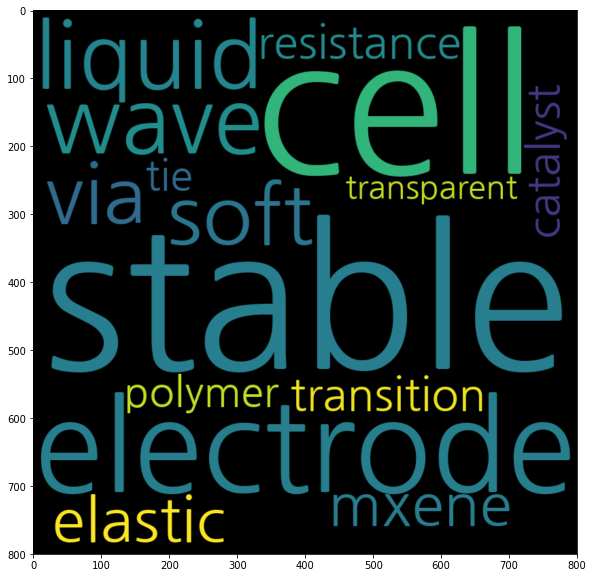

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(array_tf, interpolation="bilinear")
plt.show()
fig.savefig('./result/tf_base_wc_english.png')


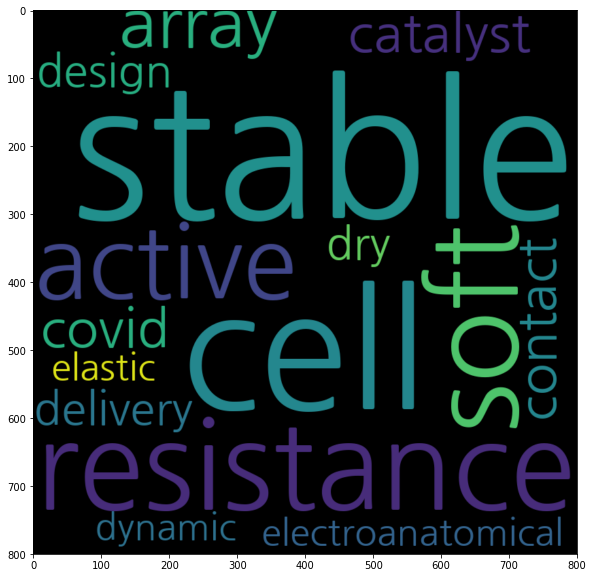

In [18]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(array_count, interpolation="bilinear")
plt.show()
fig.savefig('./result/count_base_wc_english.png')